In [186]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import copy
import numpy as np
from models.fno import SFNO
from models.pfno import PNO_Wrapper, PFNO, PSFNO
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples
from data.datasets import SSWEDataset
from evaluate import generate_samples
from utils.train_utils import autoregressive_step
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cmcrameri
import cmcrameri.cm as cmc
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib import colormaps as cmp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

plt.rcParams['image.cmap'] = "cmc.vik"

In [187]:
batch_size = 16
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval
eval_horizon = 1


data_dir = "../../data/SSWE/processed/"

checkpoint_path = "/home/groups/ai/scholl/pfno/weights/sswe/fno/"

# 1 step ahead
sr_dropout_path = checkpoint_path + "20241002_140510_sswe_sfno_sr_dropout_1/Datetime_20241002_140512_Loss_SSWE_SFNO_scoring-rule-dropout_dropout_0.01.pt"
laplace_path = checkpoint_path + "20241001_113502_sswe_sfno_laplace_1/Datetime_20241001_113503_Loss_SSWE_SFNO_laplace_dropout_0.001.pt"
dropout_path = checkpoint_path + "20240925_134205_sswe_sfno_dropout_1/Datetime_20240925_134206_Loss_SSWE_SFNO_dropout_dropout_0.01.pt"
sr_reparam_path = checkpoint_path + "20241004_100858_sswe_sfno_reparam_1/Datetime_20241004_100900_Loss_SSWE_SFNO_scoring-rule-reparam_dropout_0.005.pt"

# 2 steps ahead

In [188]:
test_data = SSWEDataset(data_dir, test = True, pred_horizon = eval_horizon, return_all = False)
x,y,t = test_data.get_coordinates()
Lons, Lats = np.meshgrid(y,x)
L = test_data.get_domain_range()
weights = test_data.eval_weights
nlon = test_data.nlon

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
n_test = len(test_loader)

In [189]:
dropout_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.01).to(device)
dropout_cp = torch.load(dropout_path, map_location=torch.device(device))
dropout_model.load_state_dict(dropout_cp)

laplace_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.001).to(device)
la_model = LA_Wrapper(laplace_model)
la_model.load_state_dict(torch.load(laplace_path))
la_model.load_la_state_dict(torch.load(laplace_path[:-3] + "_la_state.pt"))

pfno_reparam = PSFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.005, n_samples = n_samples).to(device)
pfno_cp = torch.load(sr_reparam_path, map_location=torch.device(device))
pfno_reparam.load_state_dict(pfno_cp)

sr_dropout_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.01).to(device)
sr_dropout_cp = torch.load(sr_dropout_path, map_location=torch.device(device))
pfno_dropout = PNO_Wrapper(sr_dropout_model, n_samples = n_samples)
pfno_dropout.load_state_dict(sr_dropout_cp)

<All keys matched successfully>

# Predictions

In [190]:
# Generate random samples for plotting
np.random.seed(42)
samples = np.random.randint(0,n_test,2)

In [191]:
pfno_dropout.train()
dropout_model.train()
pfno_reparam.eval()
""" Prediction """
pred_pfno_dropout = []
pred_pfno_reparam = []
pred_dropout = []
pred_la = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)
        # Dropout
        for _ in range(eval_horizon - 1):
            a = autoregressive_step("dropout", dropout_model, a)
        dropout_pred = generate_samples("dropout",dropout_model,a,u,n_samples)

        # LA
        for _ in range(eval_horizon - 1):
            a = autoregressive_step("laplace", la_model, a)
        la_pred = generate_samples("laplace",la_model,a,u,n_samples)

        # PFNO Reparam
        for _ in range(eval_horizon - 1):
            a = autoregressive_step("scoring-rule-reparam", pfno_reparam, a)
        pfno_reparam_pred = generate_samples("scoring-rule-reparam",pfno_reparam,a,u,n_samples)

        # PFNO Dropout
        for _ in range(eval_horizon - 1):
            a = autoregressive_step("scoring-rule-dropout", pfno_dropout, a)
        pfno_dropout_pred = generate_samples("scoring-rule-dropout",pfno_dropout,a,u,n_samples)

        pred_dropout.append( dropout_pred )
        pred_pfno_dropout.append( pfno_dropout_pred )
        pred_pfno_reparam.append( pfno_reparam_pred )
        pred_la.append( la_pred )


pred_pfno_dropout = torch.cat(pred_pfno_dropout, dim = 0).cpu().numpy()
pred_pfno_reparam = torch.cat(pred_pfno_reparam, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()

In [192]:
def plot_statistics(truth, preds, names, grid, save_path = None, alpha = 0.05):
    n_models = len(preds)
    lat, lon = grid
    truth = truth.squeeze()

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size


    # Define projection
    proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)

    # Discrete colorbar
    viridis = cmp.get_cmap('viridis')    
    col_dict = {0: viridis(0),
                1: viridis(0.999)}

    # We create a colormar from our list of colors
    cmap_coverage = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Get scalings
    pred_array = np.array(preds)
    mse_norm = Normalize(vmin = np.power((truth - pred_array.mean(axis = -1)),2).min(), vmax = np.power((truth - pred_array.mean(axis = -1)),2).max())
    std_norm = Normalize(vmin = 0, vmax = pred_array.std(axis = -1).max())
    

    fig, axs = plt.subplots(3,n_models, figsize = (18,12), sharex=True, sharey=True, subplot_kw={'projection': proj},
                            layout = "constrained")

        
    for m, pred in enumerate(preds):        
        pred = pred.squeeze()
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        im1 = axs[0,m].pcolormesh(lon, lat ,np.power((truth - pred.mean(axis = -1)),2), cmap = "cmc.vik", norm = mse_norm, rasterized = True,transform=ccrs.PlateCarree(), antialiased = False,)
        im2 = axs[1,m].pcolormesh(lon, lat,pred.std(axis = -1), cmap = "cmc.lajolla", norm = std_norm, rasterized = True, transform=ccrs.PlateCarree(), antialiased = False)
        im3 = axs[2,m].pcolormesh(lon, lat,coverage, cmap = cmap_coverage, rasterized = True,transform=ccrs.PlateCarree(), antialiased = False)
        axs[0,m].set_title(names[m], fontsize = 24)
        print(f"{names[m]}- Coverage: {coverage.mean()}")
    cb1 = fig.colorbar(im1, ax = axs[0,m])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Squared error',size=title_size)
    cb2 = fig.colorbar(im2, ax = axs[1,m], label = "Standard deviation")
    cb2.ax.tick_params(labelsize=tick_size)
    cb2.set_label('Standard deviation',size=title_size)
    cb3 = fig.colorbar(im3, ax = axs[2,m], label = "", ticks = np.array([0,1]))
    cb3.ax.tick_params(labelsize=tick_size)
    cb3.set_label(r"Coverage ($\alpha = 0.05$)",size=title_size)

    for i in range(3):
        axs[i,0].set_xticks([])
        axs[i,0].set_yticks([])
   # fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

In [193]:
def plot_predictions(truth, preds, names, grid, save_path = None, alpha = 0.05):
    n_models = len(preds)
    lat, lon = grid
    truth = truth.squeeze()

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size


    # Define projection
    proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)

    # Discrete colorbar
    viridis = cmp.get_cmap('viridis')    
    col_dict = {0: viridis(0),
                1: viridis(0.999)}

    # We create a colormar from our list of colors
    cmap_coverage = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Get scalings
    pred_array = np.array(preds)
    pred_norm = Normalize(vmin = pred_array.mean(axis = -1).min(), vmax = pred_array.mean(axis = -1).max())
    std_norm = Normalize(vmin = 0, vmax = pred_array.std(axis = -1).max())
    

    fig, axs = plt.subplots(4,n_models, figsize = (18,15), sharex=True, sharey=True, subplot_kw={'projection': proj},
                            layout = "constrained")

        
    for m, pred in enumerate(preds):        
        pred = pred.squeeze()
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        im1 = axs[0,m].pcolormesh(lon, lat ,truth , cmap = "cmc.vik", rasterized = True,transform=ccrs.PlateCarree(), antialiased = False, norm = pred_norm)
        im1 = axs[1,m].pcolormesh(lon, lat ,pred.mean(axis = -1), cmap = "cmc.vik", norm = pred_norm, rasterized = True,transform=ccrs.PlateCarree(), antialiased = False)
        im2 = axs[2,m].pcolormesh(lon, lat,pred.std(axis = -1), cmap = "cmc.lajolla", norm = std_norm, rasterized = True, transform=ccrs.PlateCarree(), antialiased = False)
        im3 = axs[3,m].pcolormesh(lon, lat,coverage, cmap = cmap_coverage, rasterized = True,transform=ccrs.PlateCarree(), antialiased = False)
        axs[0,m].set_title(names[m], fontsize = 24)
        print(f"{names[m]}- Coverage: {coverage.mean()}")
    cb1 = fig.colorbar(im1, ax = axs[0,m])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Ground truth',size=title_size)
    cb2 = fig.colorbar(im1, ax = axs[1,m])
    cb2.ax.tick_params(labelsize=tick_size) 
    cb2.set_label('Prediction',size=title_size)
    cb3 = fig.colorbar(im2, ax = axs[2,m], label = "Standard deviation")
    cb3.ax.tick_params(labelsize=tick_size)
    cb3.set_label('Standard deviation',size=title_size)
    cb4 = fig.colorbar(im3, ax = axs[3,m], label = "", ticks = np.array([0,1]))
    cb4.ax.tick_params(labelsize=tick_size)
    cb4.set_label(r"Coverage ($\alpha = 0.05$)",size=title_size)

    for i in range(4):
        axs[i,0].set_xticks([])
        axs[i,0].set_yticks([])
   # fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

# Plots

In [194]:
idx = 1
channel = 0

a,u = test_data.__getitem__(samples[idx])
a = a.unsqueeze(0).numpy()
u = u.unsqueeze(0).numpy()[:,channel]

preds = [pred_dropout[idx, channel], pred_la[idx,channel], pred_pfno_dropout[idx, channel], pred_pfno_reparam[idx, channel]]
names = ['Dropout', 'Laplace', 'PNO Dropout', 'PNO Reparam']

Dropout- Coverage: 0.6610107421875
Laplace- Coverage: 0.997894287109375
PNO Dropout- Coverage: 0.98236083984375
PNO Reparam- Coverage: 0.534027099609375


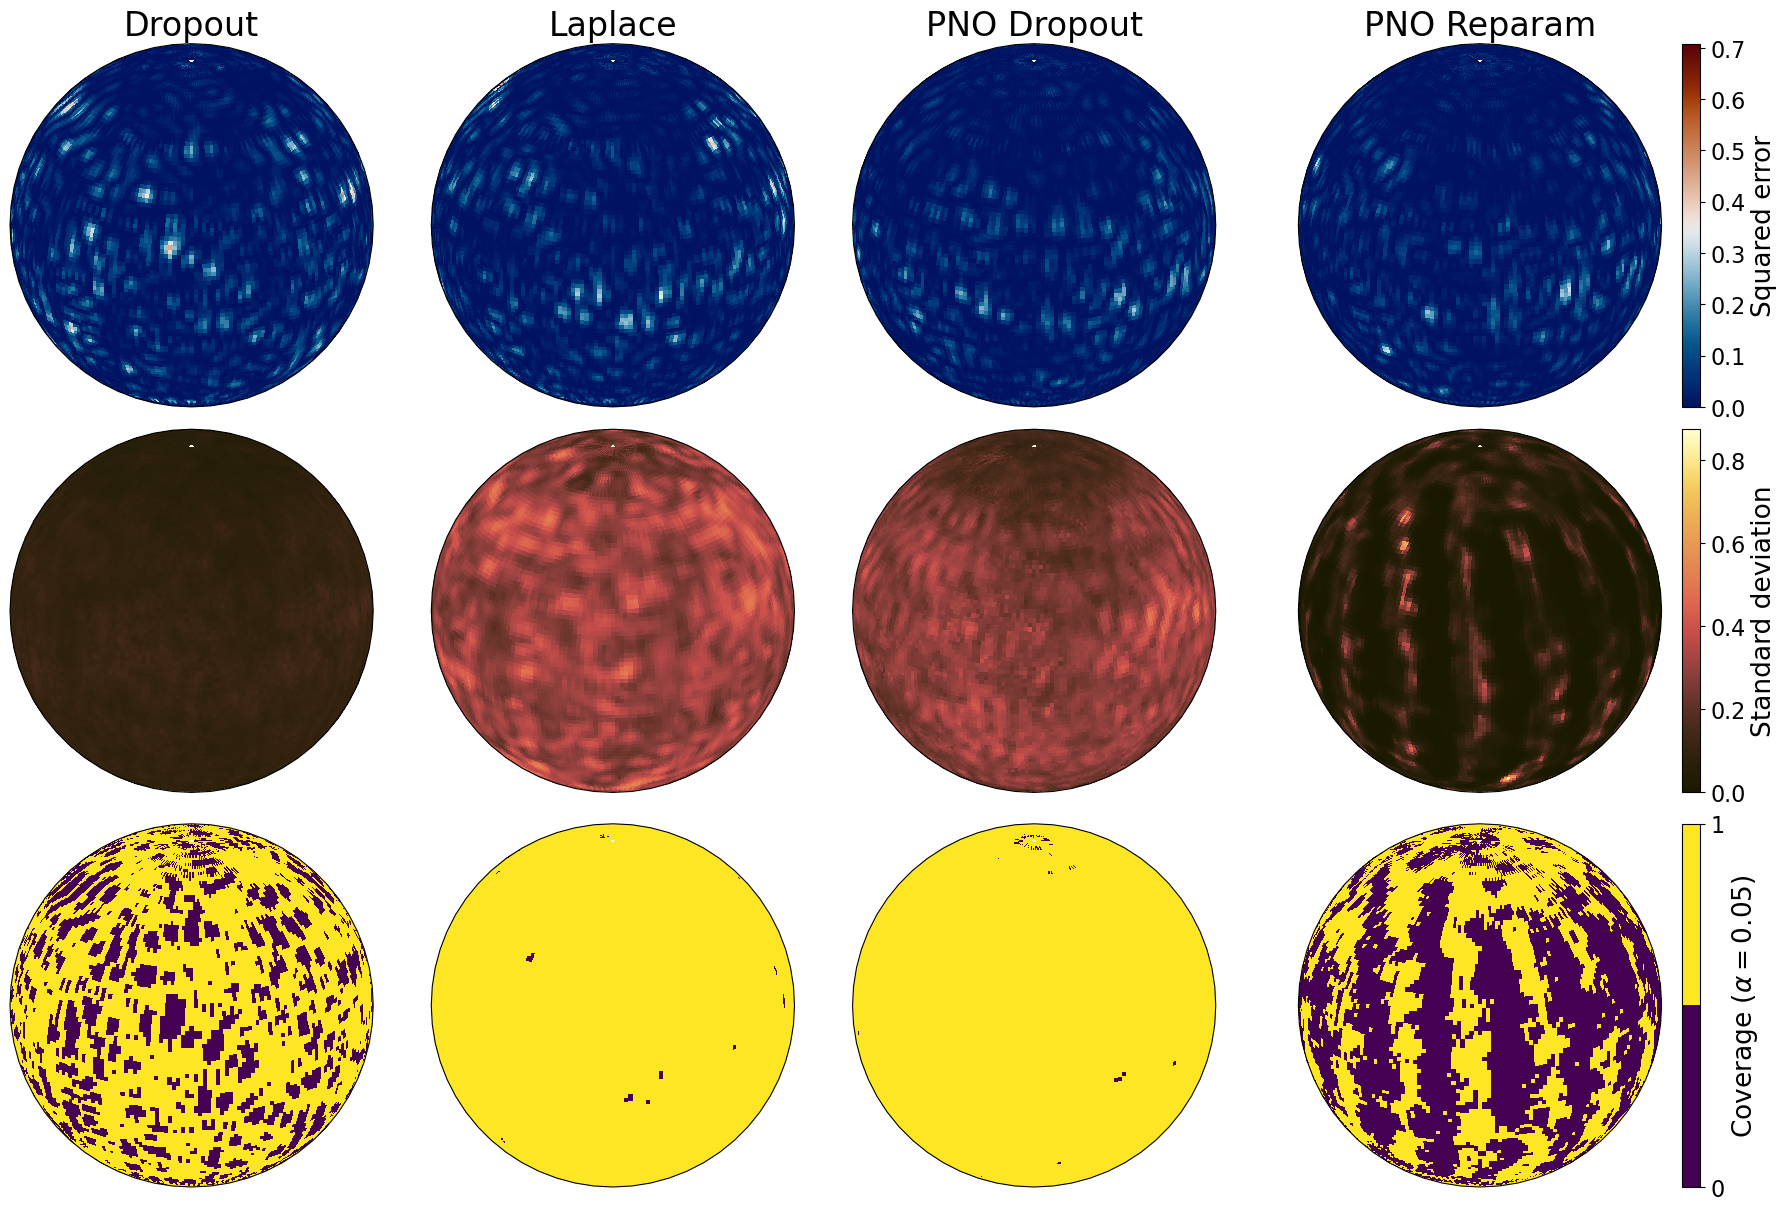

In [195]:
plot_statistics(u, preds, names, (Lats,Lons), save_path = f"plots/sswe_statistics_{eval_horizon}h.pdf", alpha = 0.05)

Dropout- Coverage: 0.6610107421875
Laplace- Coverage: 0.997894287109375
PNO Dropout- Coverage: 0.98236083984375
PNO Reparam- Coverage: 0.534027099609375


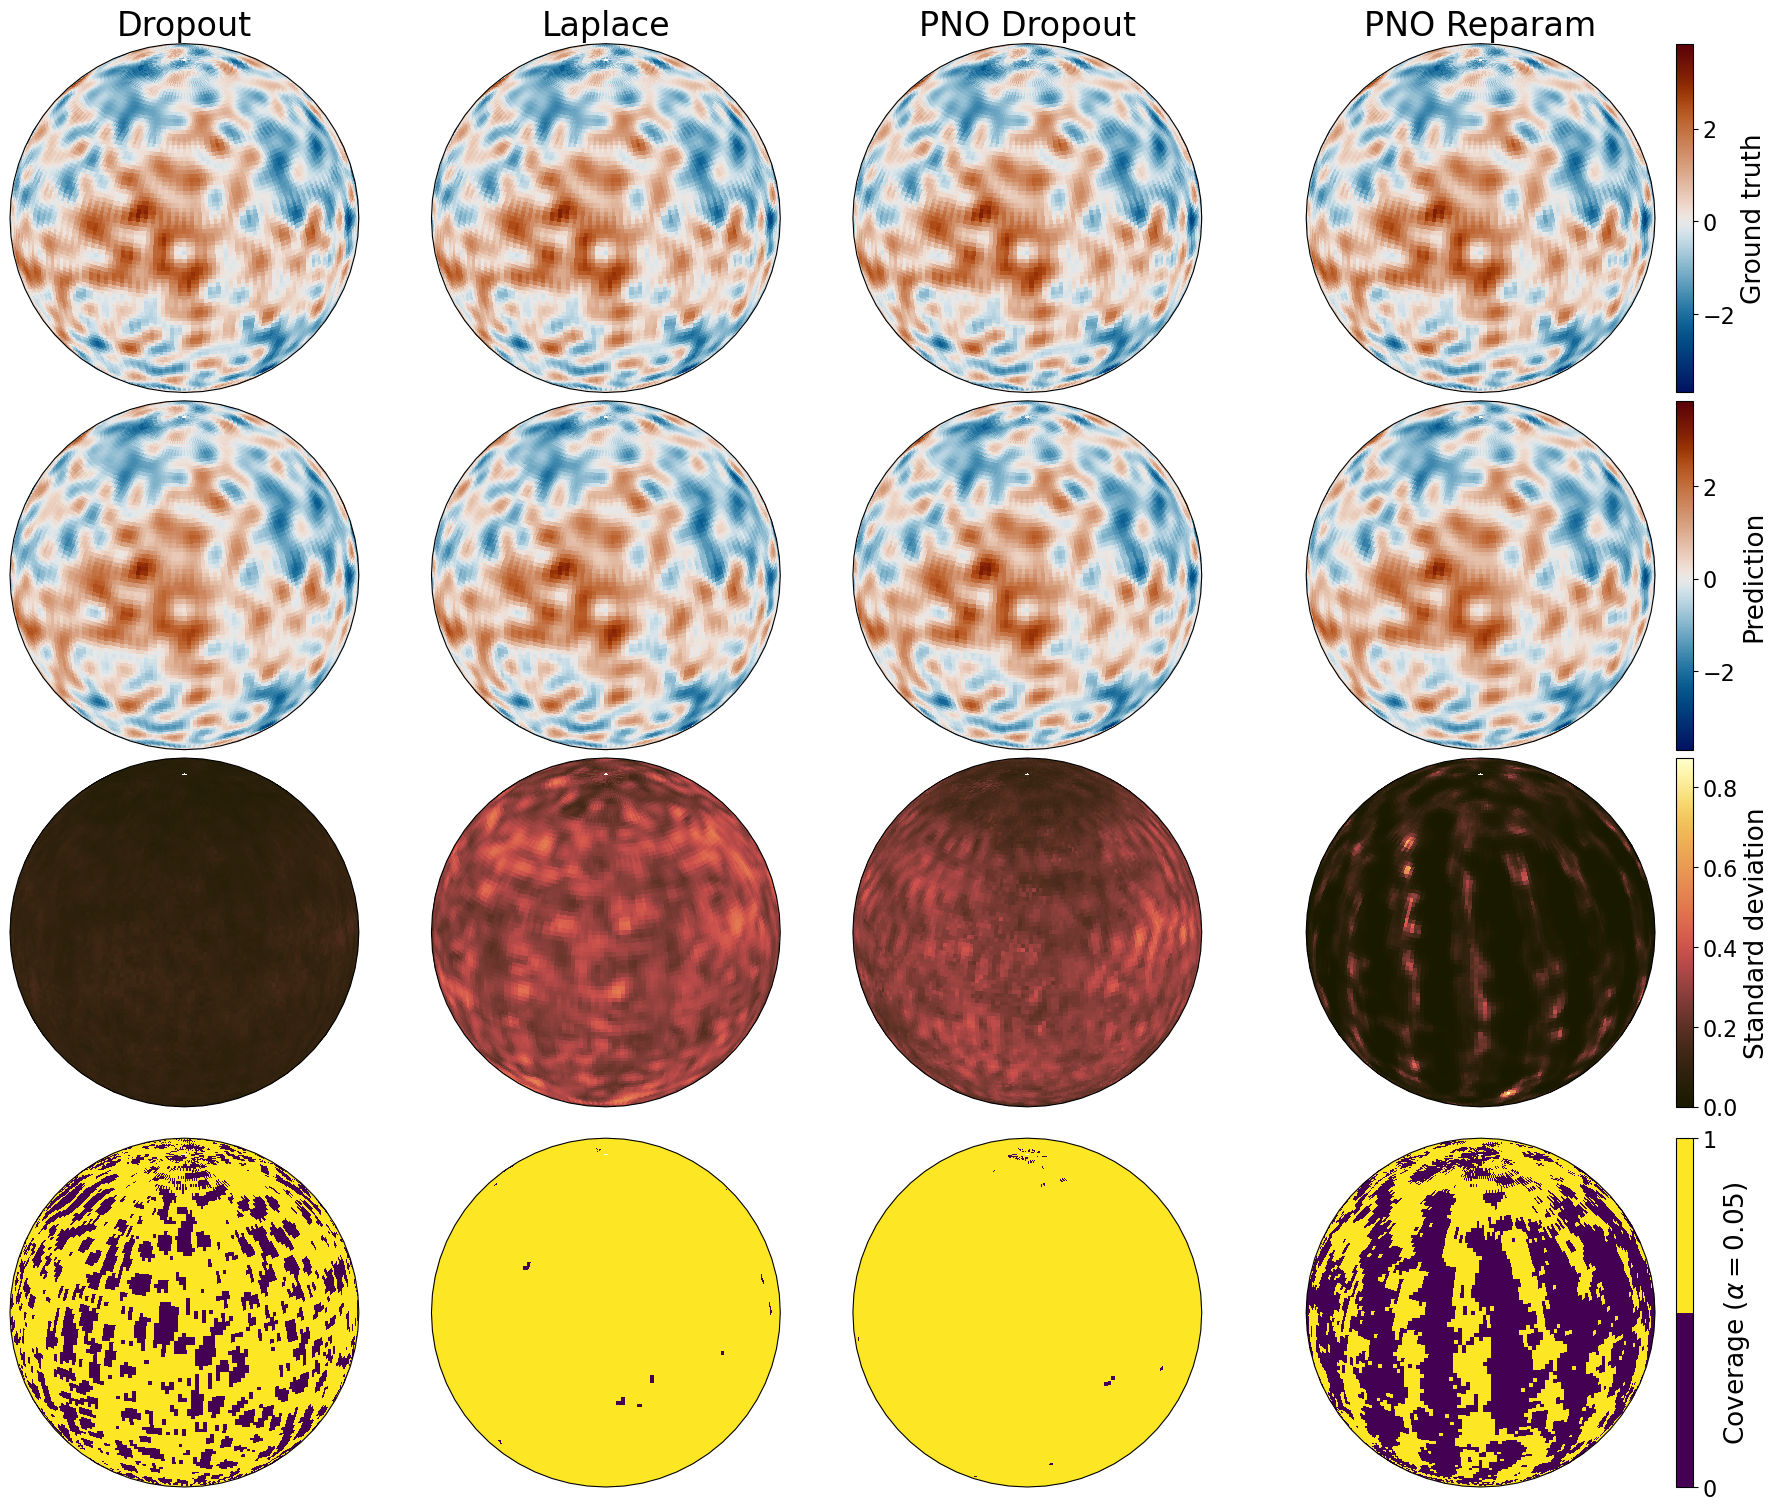

In [196]:
plot_predictions(u, preds, names, (Lats,Lons), save_path = f"plots/sswe_predictions_{eval_horizon}h.pdf", alpha = 0.05)

# Plot time dynamics of PFNO

In [176]:
batch_size = 16
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval
eval_horizon = 10

# Hres
data_dir = "../../data/SSWE/hres/"

checkpoint_path = "/home/groups/ai/scholl/pfno/weights/sswe/fno/"

# 2 steps ahead
sr_dropout_path = checkpoint_path + "20241004_102958_sswe_sfno_sr_dropout_2/Datetime_20241004_102958_Loss_SSWE_SFNO_scoring-rule-dropout_dropout_0.01.pt"
laplace_path = checkpoint_path + "20241002_140510_sswe_sfno_laplace_2/Datetime_20241002_140512_Loss_SSWE_SFNO_laplace_dropout_0.001.pt"
dropout_path = checkpoint_path + "20241001_113458_sswe_sfno_dropout_2/Datetime_20241001_113459_Loss_SSWE_SFNO_dropout_dropout_0.01.pt"
sr_reparam_path = checkpoint_path + "20241008_125613_sswe_sfno_reparam_2/Datetime_20241008_125614_Loss_SSWE_SFNO_scoring-rule-reparam_dropout_0.005.pt"


# 1 step ahead
sr_dropout_path = checkpoint_path + "20241002_140510_sswe_sfno_sr_dropout_1/Datetime_20241002_140512_Loss_SSWE_SFNO_scoring-rule-dropout_dropout_0.01.pt"
laplace_path = checkpoint_path + "20241001_113502_sswe_sfno_laplace_1/Datetime_20241001_113503_Loss_SSWE_SFNO_laplace_dropout_0.001.pt"
dropout_path = checkpoint_path + "20240925_134205_sswe_sfno_dropout_1/Datetime_20240925_134206_Loss_SSWE_SFNO_dropout_dropout_0.01.pt"
sr_reparam_path = checkpoint_path + "20241004_100858_sswe_sfno_reparam_1/Datetime_20241004_100900_Loss_SSWE_SFNO_scoring-rule-reparam_dropout_0.005.pt"

In [177]:

test_data = SSWEDataset(data_dir, test = True, pred_horizon = eval_horizon, return_all = True)
x,y,t = test_data.get_coordinates()
Lons, Lats = np.meshgrid(y,x)
L = test_data.get_domain_range()
weights = test_data.eval_weights
nlon = test_data.nlon

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
n_test = len(test_loader)

In [178]:
dropout_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.01).to(device)
dropout_cp = torch.load(dropout_path, map_location=torch.device(device))
dropout_model.load_state_dict(dropout_cp)

laplace_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.001).to(device)
la_model = LA_Wrapper(laplace_model)
la_model.load_state_dict(torch.load(laplace_path))
la_model.load_la_state_dict(torch.load(laplace_path[:-3] + "_la_state.pt"))

pfno_reparam = PSFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.005, n_samples = n_samples).to(device)
pfno_cp = torch.load(sr_reparam_path, map_location=torch.device(device))
pfno_reparam.load_state_dict(pfno_cp)

sr_dropout_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.01).to(device)
sr_dropout_cp = torch.load(sr_dropout_path, map_location=torch.device(device))
pfno_dropout = PNO_Wrapper(sr_dropout_model, n_samples = n_samples)
pfno_dropout.load_state_dict(sr_dropout_cp)

<All keys matched successfully>

In [179]:
# Generate random samples for plotting
np.random.seed(2)
samples = np.random.randint(0,n_test,1)

In [180]:
model = pfno_reparam
model.train()
""" Prediction """
pred_pfno = []
sd_pfno = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)

        # PFNO
        out = model(a, n_samples = n_samples)
        sd_pfno.append( out.std(axis = -1) )
        out = out.mean(axis = -1)
        pred_pfno.append( out )

        for _ in range(1,eval_horizon):        
            out = model(out, n_samples = n_samples)
            sd_pfno.append( out.std(axis = -1) )
            out = out.mean(axis = -1)
            pred_pfno.append( out )

truth = u.squeeze().cpu().numpy()
inp = a.squeeze().cpu().numpy()
pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
sd_pfno = torch.cat(sd_pfno, dim = 0).cpu().numpy()

In [181]:
def plot_error_dynamics(truth, pred, sd, name, steps, grid, save_path = None, alpha = 0.05):
    n_steps = len(steps)
    lat, lon = grid
    truth = truth.squeeze()

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size


    # Define projection
    proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)

    # Get scalings
   # pred_array = np.array(preds)
    mse_norm = Normalize(vmin = np.power((pred - truth),2).min(), vmax = np.power((pred-truth),2).max())
    sd_norm = Normalize(vmin = sd.min(), vmax = sd.max())
    

    fig, axs = plt.subplots(2,n_steps, figsize = (20,10), sharex=True, sharey=True, subplot_kw={'projection': proj},
                            layout = "constrained")

        
    for t, step in enumerate(steps):        
        pred = pred.squeeze()
        # Calculate coverage
        im1 = axs[0,t].pcolormesh(lon, lat ,np.power((truth[step]-pred[step]),2), cmap = "cmc.vik", rasterized = True,transform=ccrs.PlateCarree(), antialiased = False, norm = mse_norm)
        im2 = axs[1,t].pcolormesh(lon, lat, sd[step], cmap = "cmc.lajolla", rasterized = True, transform=ccrs.PlateCarree(), antialiased = False, norm = sd_norm)
        axs[0,t].set_title(f"+{step+1}h", fontsize = 24)

    cb1 = fig.colorbar(im1, ax = axs[0,t])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Squared error',size=title_size)
    cb2 = fig.colorbar(im2, ax = axs[1,t])
    cb2.ax.tick_params(labelsize=tick_size)
    cb2.set_label("Standard deviation",size=title_size)

    for i in range(2):
        axs[i,0].set_xticks([])
        axs[i,0].set_yticks([])
   # fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

In [182]:
def plot_dynamics(truth, pred, sd, name, steps, grid, save_path = None, alpha = 0.05):
    n_steps = len(steps)
    lat, lon = grid
    truth = truth.squeeze()

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size


    # Define projection
    proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)

    # Get scalings
   # pred_array = np.array(preds)
    truth_norm = Normalize(vmin = truth.min(), vmax = truth.max())
    pred_norm = Normalize(vmin = pred.min(), vmax = pred.max())
    sd_norm = Normalize(vmin = sd.min(), vmax = sd.max())
    

    fig, axs = plt.subplots(3,n_steps, figsize = (20,10), sharex=True, sharey=True, subplot_kw={'projection': proj},
                            layout = "constrained")

        
    for t, step in enumerate(steps):        
        pred = pred.squeeze()
        # Calculate coverage
        im1 = axs[0,t].pcolormesh(lon, lat ,truth[step], cmap = "cmc.vik", rasterized = True,transform=ccrs.PlateCarree(), antialiased = False, norm = truth_norm)
        im2 = axs[1,t].pcolormesh(lon, lat, pred[step], cmap = "cmc.vik", rasterized = True, transform=ccrs.PlateCarree(), antialiased = False, norm = truth_norm)
        im3 = axs[2,t].pcolormesh(lon, lat, sd[step], cmap = "cmc.lajolla", rasterized = True, transform=ccrs.PlateCarree(), antialiased = False, norm = sd_norm)
        axs[0,t].set_title(f"+{step+1}h", fontsize = 24)

    cb1 = fig.colorbar(im1, ax = axs[0,t])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Ground truth',size=title_size)
    cb2 = fig.colorbar(im2, ax = axs[1,t])
    cb2.ax.tick_params(labelsize=tick_size)
    cb2.set_label('Mean prediction',size=title_size)
    cb3 = fig.colorbar(im3, ax = axs[2,t])
    cb3.ax.tick_params(labelsize=tick_size)
    cb3.set_label("Standard deviation",size=title_size)

    for i in range(3):
        axs[i,0].set_xticks([])
        axs[i,0].set_yticks([])
   # fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

# Plot prediction history

In [183]:
channel = 0

a,u = test_data.__getitem__(samples[0])
a = a.unsqueeze(0).numpy()
u = u.unsqueeze(0).numpy()

pred = pred_pfno[:, channel]
sd = sd_pfno[:, channel]
truth = u[0,channel]
name = "pno_dropout"

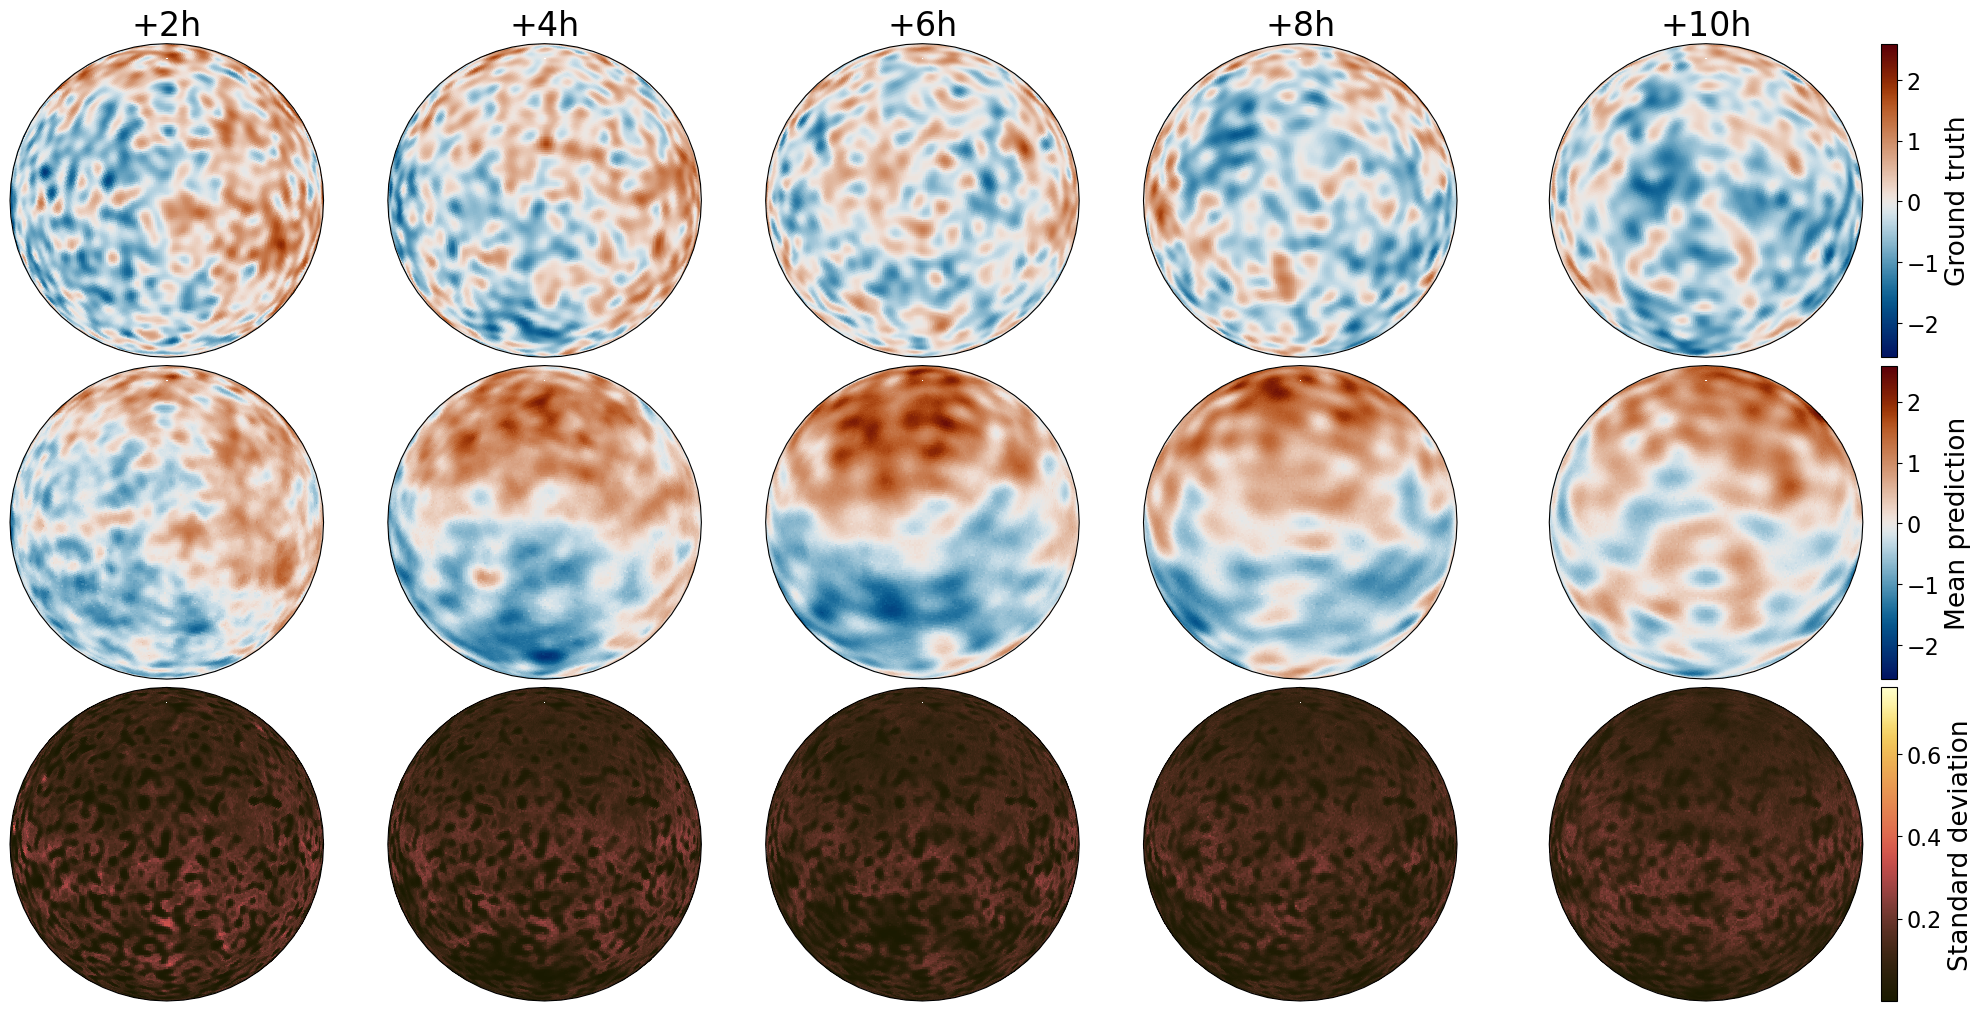

In [184]:
plot_dynamics(truth, pred, sd, name, steps = [1,3,5,7,9], grid = (Lats, Lons), save_path= f"plots/sswe_prediction_dynamics_{name}.pdf")

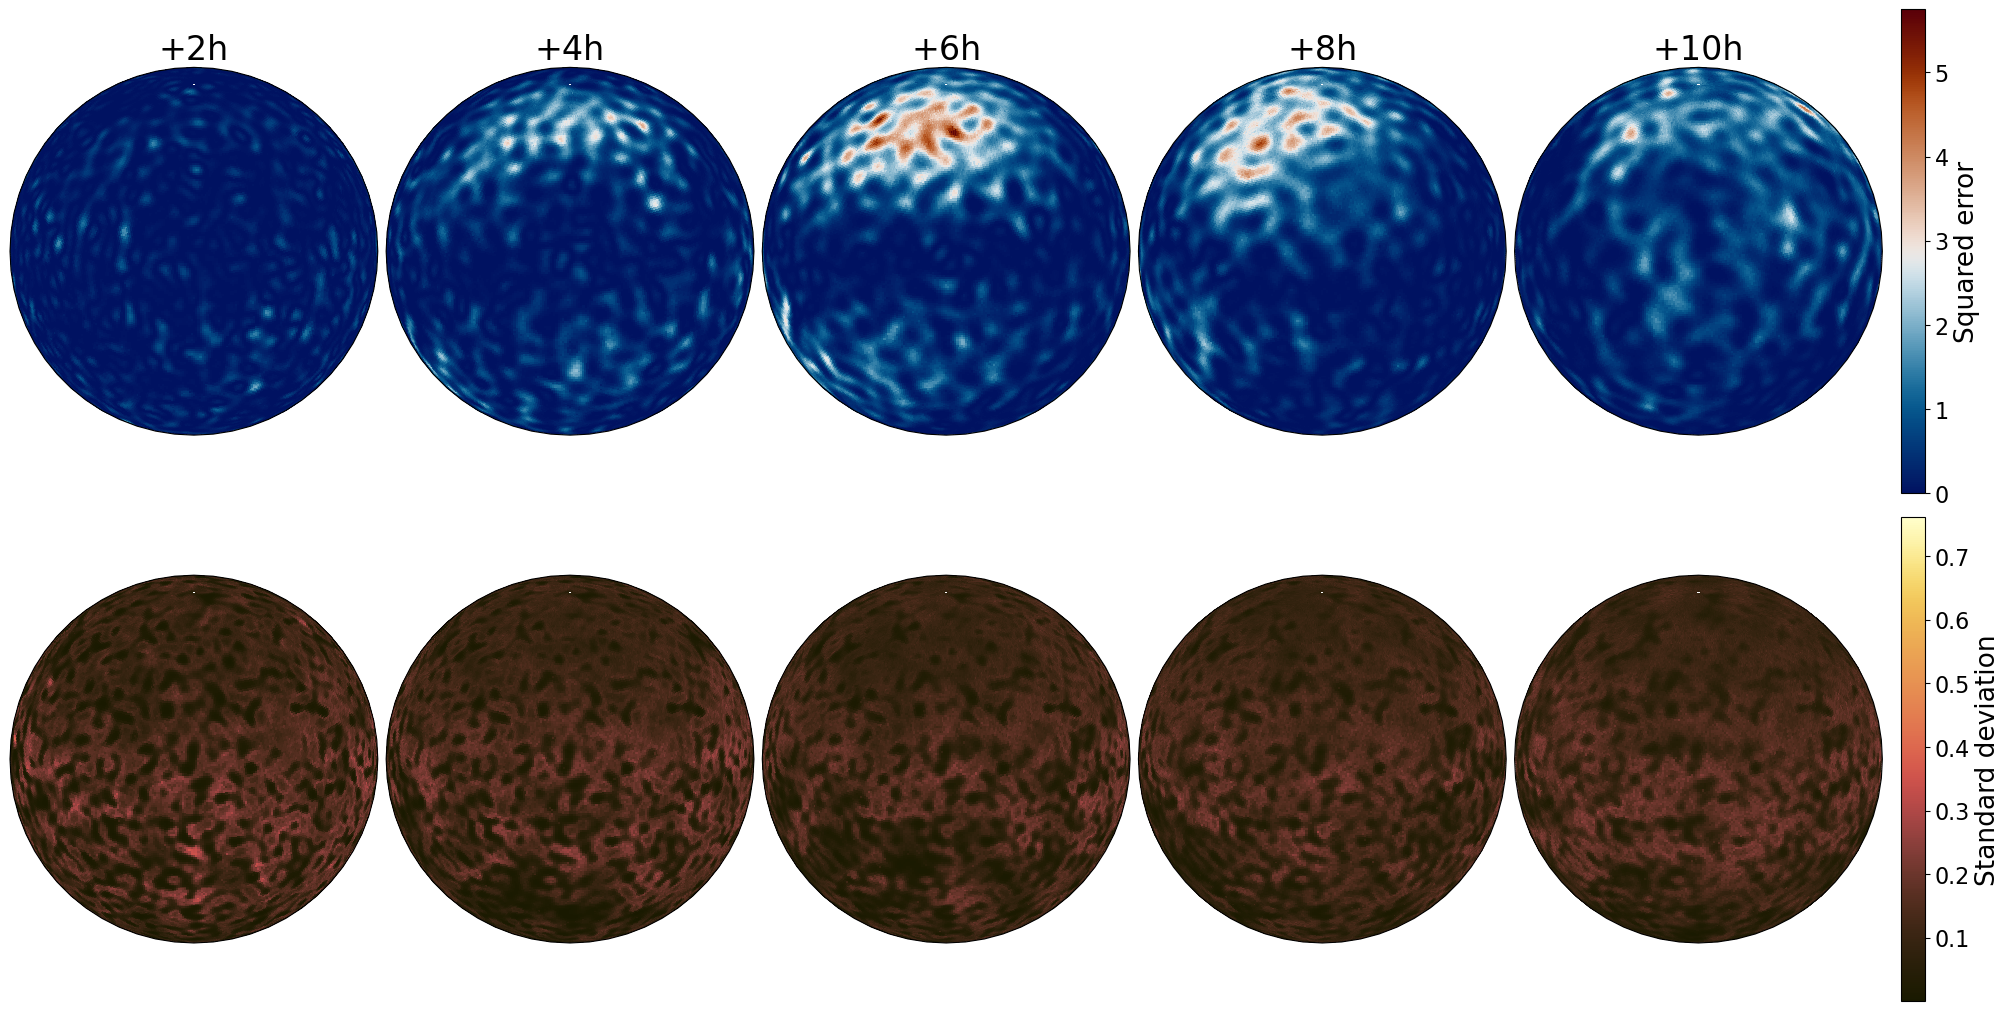

In [185]:
plot_error_dynamics(truth, pred, sd,name, steps = [1,3,5,7,9], grid = (Lats, Lons), save_path= f"plots/sswe_error_dynamics_{name}.pdf")

ValueError: not enough values to unpack (expected 2, got 1)

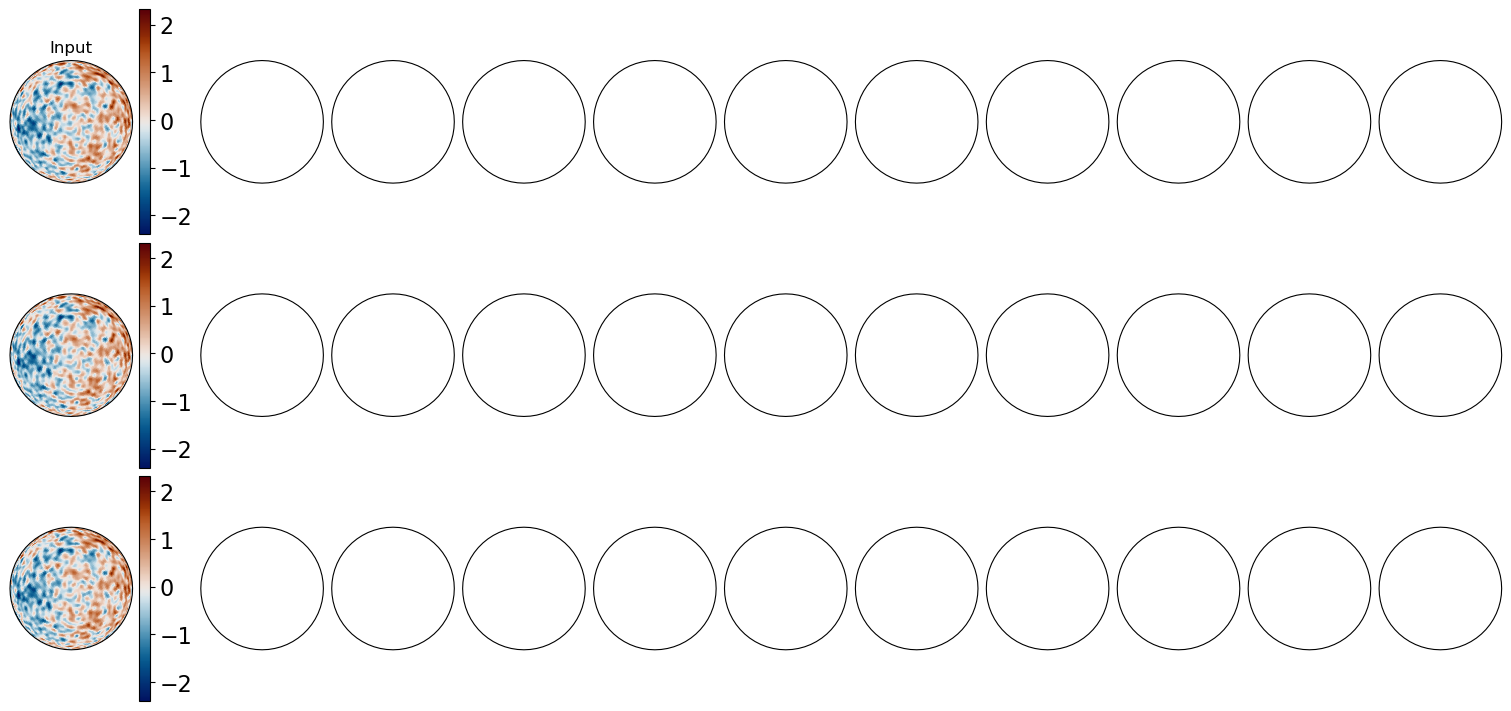

In [145]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(3,(eval_horizon+1), figsize = (15,7), subplot_kw={'projection': proj}, layout = "constrained")
for i in range(3):
    im = axs[i,0].pcolormesh(Lons, Lats, inp[0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)
    axs[0,0].set_title("Input")

for i in range(eval_horizon):
    im = axs[0,i+1].pcolormesh(Lons, Lats, truth[0,i], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[1,i+1].pcolormesh(Lons, Lats, pred_dropout[i,0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[2,i+1].pcolormesh(Lons, Lats, pred_pfno[i,0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    axs[0,i+1].set_title(f"t+{i+1}")


axs[0,0].set_ylabel("Truth")
axs[1,0].set_ylabel("Dropout")
axs[2,0].set_ylabel("PFNO")

# Tests

In [16]:
batch_size = 16
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval
eval_horizon = 5
n_train_steps = 2

In [17]:
data_dir = "../data/SSWE/processed/"
train_data = SSWEDataset(data_dir, test = False, pred_horizon = n_train_steps, return_all = True)
test_data = SSWEDataset(data_dir, test = True, pred_horizon = eval_horizon, return_all = True)
train_data, val_data = random_split(train_data, lengths = [0.8,0.2], generator = torch.Generator().manual_seed(42))


x,y,t = test_data.get_coordinates()
L = test_data.get_domain_range()
weights = test_data.eval_weights
nlon = test_data.nlon

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)


n_train = len(train_loader)
n_val = len(val_data)
n_test = len(test_data)

In [18]:
# hidden_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense', dropout = dropout_rate)
# hidden_model = hidden_model.to(device)
pfno_model = PSFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=256, factorization='dense', dropout = None, n_samples = 3,
                   lifting_channels = 256)
pfno_model.to(device)

# pfno_model = PNO_Wrapper(hidden_model, n_samples = 3)
# pfno_model.to(device)

n_params = count_model_params(pfno_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()

pfno_model.load_state_dict(torch.load("../results/sswe_test/normal.pt"))


Our model has 294054 parameters.


/tmp/ipykernel_22957/1311851888.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pfno_model.load_state_dict(torch.load("../results/sswe_test/normal.pt"))


<All keys matched successfully>

In [19]:
# Losses and parameters
l2loss = SphericalL2Loss(nlon = nlon, weights = weights.to(device))
energy_score = EnergyScore(type = "spherical", nlon = nlon, weights = weights.to(device))

In [36]:
pfno_model.eval()
""" Prediction """
mse_pfno = 0
es_pfno = 0
coverage_pfno = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u[:,:,-1].to(device)
        batch_size = a.shape[0]

        # Autoregressive steps
        for _ in range(eval_horizon-1):
            a = pfno_model(a, n_samples = 10)
            a = a.mean(axis = -1)

        out = pfno_model(a, n_samples = n_samples)
        mse_pfno += l2loss(out.mean(axis = -1), u).item() * batch_size / n_test
        es_pfno += energy_score(out, u).item() *batch_size / n_test
        # Calculate coverage
        q_lower = torch.quantile(out,alpha/2, axis = -1)
        q_upper = torch.quantile(out,1-alpha/2, axis = -1)
        coverage_pfno += ((u>q_lower) & (u<q_upper)).float().mean().item() *batch_size / n_test



print('MSE:', mse_pfno)
print('ES:', es_pfno)
print(f"Coverage: {coverage_pfno*100:.4f}%")

MSE: 1.0699061161132124
ES: 0.7667232623673822
Coverage: 85.8285%


In [30]:
sample = np.random.randint(0,len(test_data))
print(sample)

""" Prediction """
truth = []
pred_pfno = []
with torch.no_grad():
    a,u = test_data.__getitem__(sample)
    a = a.to(device).unsqueeze(0)
    u = u[:,-1].to(device).unsqueeze(0)
    # PFNO
    out = pfno_model(a, n_samples = n_samples)
    for _ in range(1,eval_horizon-1):
        out = pfno_model(out.mean(axis = -1))
    pfno_pred = pfno_model(out.mean(axis = -1), n_samples = n_samples)
        

    pred_pfno.append( pfno_pred )
    truth.append( u )


pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
truth = torch.cat(truth, dim = 0).cpu().numpy()

70


In [31]:
idx = 0
var = 0
preds = [pred_pfno]

Text(0, 0.5, 'PFNO')

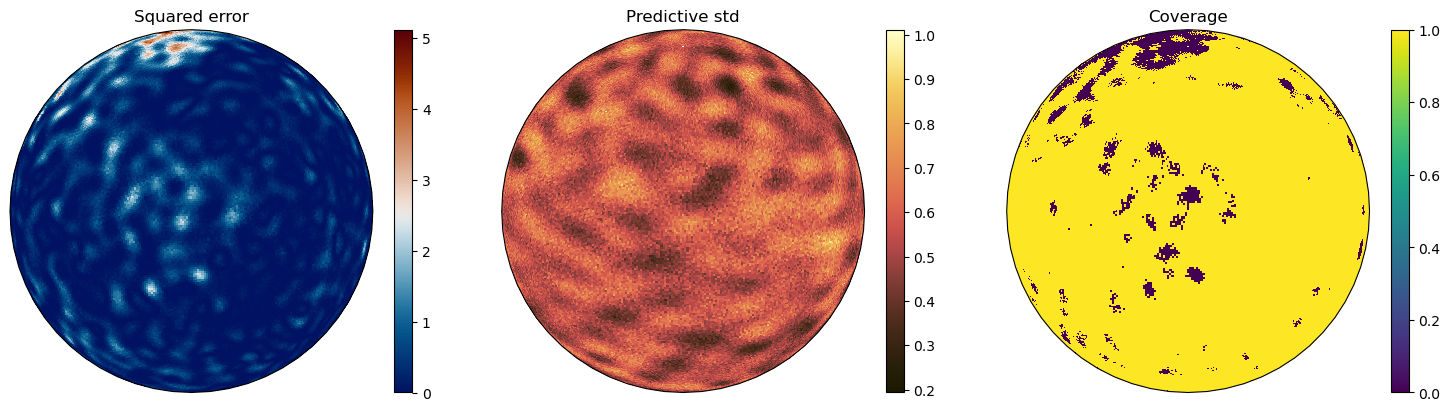

In [32]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(1,3, figsize = (15,4), subplot_kw={'projection': proj}, layout = "constrained")
for i, pred in enumerate(preds):
    # im = axs[i,0].pcolormesh(Lons, Lats, truth[idx,0], transform=ccrs.PlateCarree(), antialiased = False)
    # plt.colorbar(im)

    im = axs[0].pcolormesh(Lons, Lats, np.power(pred[idx,var].mean(axis = -1)-truth[idx,0],2), transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[1].pcolormesh(Lons, Lats, pred[idx,var].std(axis = -1), transform=ccrs.PlateCarree(), antialiased = False, cmap = "cmc.lajolla")
    plt.colorbar(im)

    # Calculate coverage
    q_lower = np.quantile(pred[idx,var],alpha/2, axis = -1)
    q_upper = np.quantile(pred[idx,var],1-alpha/2, axis = -1)
    coverage = (truth[idx,var]>q_lower) & (truth[idx,var]<q_upper)

    im = axs[2].pcolormesh(Lons, Lats, coverage, transform=ccrs.PlateCarree(), antialiased = False, cmap = "viridis")
    plt.colorbar(im)


axs[0].set_title("Squared error")
axs[1].set_title("Predictive std")
axs[2].set_title("Coverage")

axs[0].set_ylabel("MCDropout")
axs[0].set_ylabel("LA")
axs[0].set_ylabel("PFNO")

In [33]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(1,4, figsize = (15,4), subplot_kw={'projection': proj}, layout = "constrained")
for i, pred in enumerate(preds):
    im = axs[0].pcolormesh(Lons, Lats, truth[idx,var], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[1].pcolormesh(Lons, Lats, pred[idx,var].mean(axis = -1), transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[2].pcolormesh(Lons, Lats, pred[idx,var].std(axis = -1), transform=ccrs.PlateCarree(), antialiased = False, cmap = "cmc.lajolla")
    plt.colorbar(im)

    # Calculate coverage
    q_lower = np.quantile(pred[idx,var],alpha/2, axis = -1)
    q_upper = np.quantile(pred[idx,var],1-alpha/2, axis = -1)
    coverage = (truth[idx,var]>q_lower) & (truth[idx,var]<q_upper)

    im = axs[3].pcolormesh(Lons, Lats, coverage, transform=ccrs.PlateCarree(), antialiased = False, cmap = "viridis")
    plt.colorbar(im)


axs[0].set_title("Truth")
axs[1].set_title("Predictive mean")    
axs[2].set_title("Predictive std")
axs[3].set_title("Coverage")

axs[0].set_ylabel("MCDropout")
axs[0].set_ylabel("LA")
axs[0].set_ylabel("PFNO")

Text(0, 0.5, 'PFNO')

In [34]:
""" Prediction """
truth = []
pred_pfno = []


with torch.no_grad():
    a,u = test_data.__getitem__(sample)
    a = a.to(device).unsqueeze(0)
    u = u.to(device).unsqueeze(0)
    # PFNO
    out = pfno_model(a, n_samples = n_samples)
    out = out.mean(axis = -1)
    pred_pfno.append( out )

    for _ in range(1,eval_horizon):        
        out = pfno_model(out, n_samples = n_samples)
        out = out.mean(axis = -1)
        pred_pfno.append( out )

truth = u.squeeze().cpu().numpy()
inp = a.squeeze().cpu().numpy()
pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()

In [35]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(2,(eval_horizon+1), figsize = (15,7), subplot_kw={'projection': proj}, layout = "constrained")
for i in range(2):
    im = axs[i,0].pcolormesh(Lons, Lats, inp[var], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)
    axs[0,0].set_title("Input")

for i in range(eval_horizon):
    im = axs[0,i+1].pcolormesh(Lons, Lats, truth[var,i], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)


    im = axs[1,i+1].pcolormesh(Lons, Lats, pred_pfno[i,var], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    axs[0,i+1].set_title(f"t+{i+1}")


axs[0,0].set_ylabel("Truth")
axs[1,0].set_ylabel("PFNO")

Text(0, 0.5, 'PFNO')